<a href="https://colab.research.google.com/github/sterzoutt/DS3000A-GROUP/blob/main/DS3000A_GROUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

df = pd.read_csv("diabetes_dataset.csv");
display(df.head())
display(df.shape)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


(100000, 31)

In [2]:
#Q1.2
#dataset has no null values to replace (good)
df.isnull().sum()

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


In [3]:
df['diagnosed_diabetes'].value_counts(normalize = True)
df['diagnosed_diabetes'].value_counts(normalize = False)



diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

In [4]:
X = df.drop('diagnosed_diabetes', axis=1)
y = df['diagnosed_diabetes']


In [5]:
display(y.value_counts(normalize=False))
display(y.value_counts(normalize=True))

diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.drop(columns=['diabetes_stage'], axis=1)
df = pd.get_dummies(df, columns=['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 
                                 'smoking_status'], drop_first=True)

correlations_with_target = df.corr()['diagnosed_diabetes'].drop('diagnosed_diabetes')

correlations_with_target = correlations_with_target.sort_values(ascending=False)

corr_df = correlations_with_target.to_frame(name='Correlation with Diagnosed Diabetes')



In [7]:
# initialize an empty list to store the new column order
ordered_columns = []

ordered_columns.append('diagnosed_diabetes')

# iterate through the original DataFrame columns
for col in df.columns:
    if col != 'diagnosed_diabetes':
        ordered_columns.append(col)

# new df with proper ordering
df = df[ordered_columns]

display(df.head())

,diagnosed_diabetes,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,...,education_level_Postgraduate,income_level_Low,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Former,smoking_status_Never
0,1,58,0,215,5.7,7.9,7.9,0,0,0,...,False,False,True,False,False,False,False,False,False,True
1,0,48,1,143,6.7,6.5,8.7,0,0,0,...,False,False,False,True,False,False,False,False,True,False
2,1,60,1,57,6.4,10.0,8.1,1,0,0,...,False,False,False,True,False,False,False,True,False,True
3,1,74,0,49,3.4,6.6,5.2,0,0,0,...,False,True,False,False,False,True,False,False,False,True
4,1,46,1,109,7.2,7.4,5.0,0,0,0,...,False,False,False,True,False,True,False,False,False,True


# Selected Features and Correlation Matrix not barrier

In [8]:
correlationMatrix = df.corr()

In [9]:
cm = correlationMatrix['diagnosed_diabetes'].sort_values(ascending=False).drop('diagnosed_diabetes')
print(cm)

hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
diastolic_bp                          0.035619
cardiovascular_history                0.029793
hypertension_history                  0.027524
heart_rate                            0.022785
screen_time_hours_per_day             0.018127
gender_Other                          0.006430
income_level_Lower-Middle             0.004587
ethnicity_Other                       0.003608
education_lev

# Selected Features and Correlation Matrix >=0.05

In [10]:
selected_features_low = correlationMatrix['diagnosed_diabetes']
selected_features_low = selected_features_low[selected_features_low.abs() >= 0.05]
selected_features_low_list = selected_features_low.sort_values(ascending=False)
print(selected_features_low_list)


diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
hdl_cholesterol                      -0.051227
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


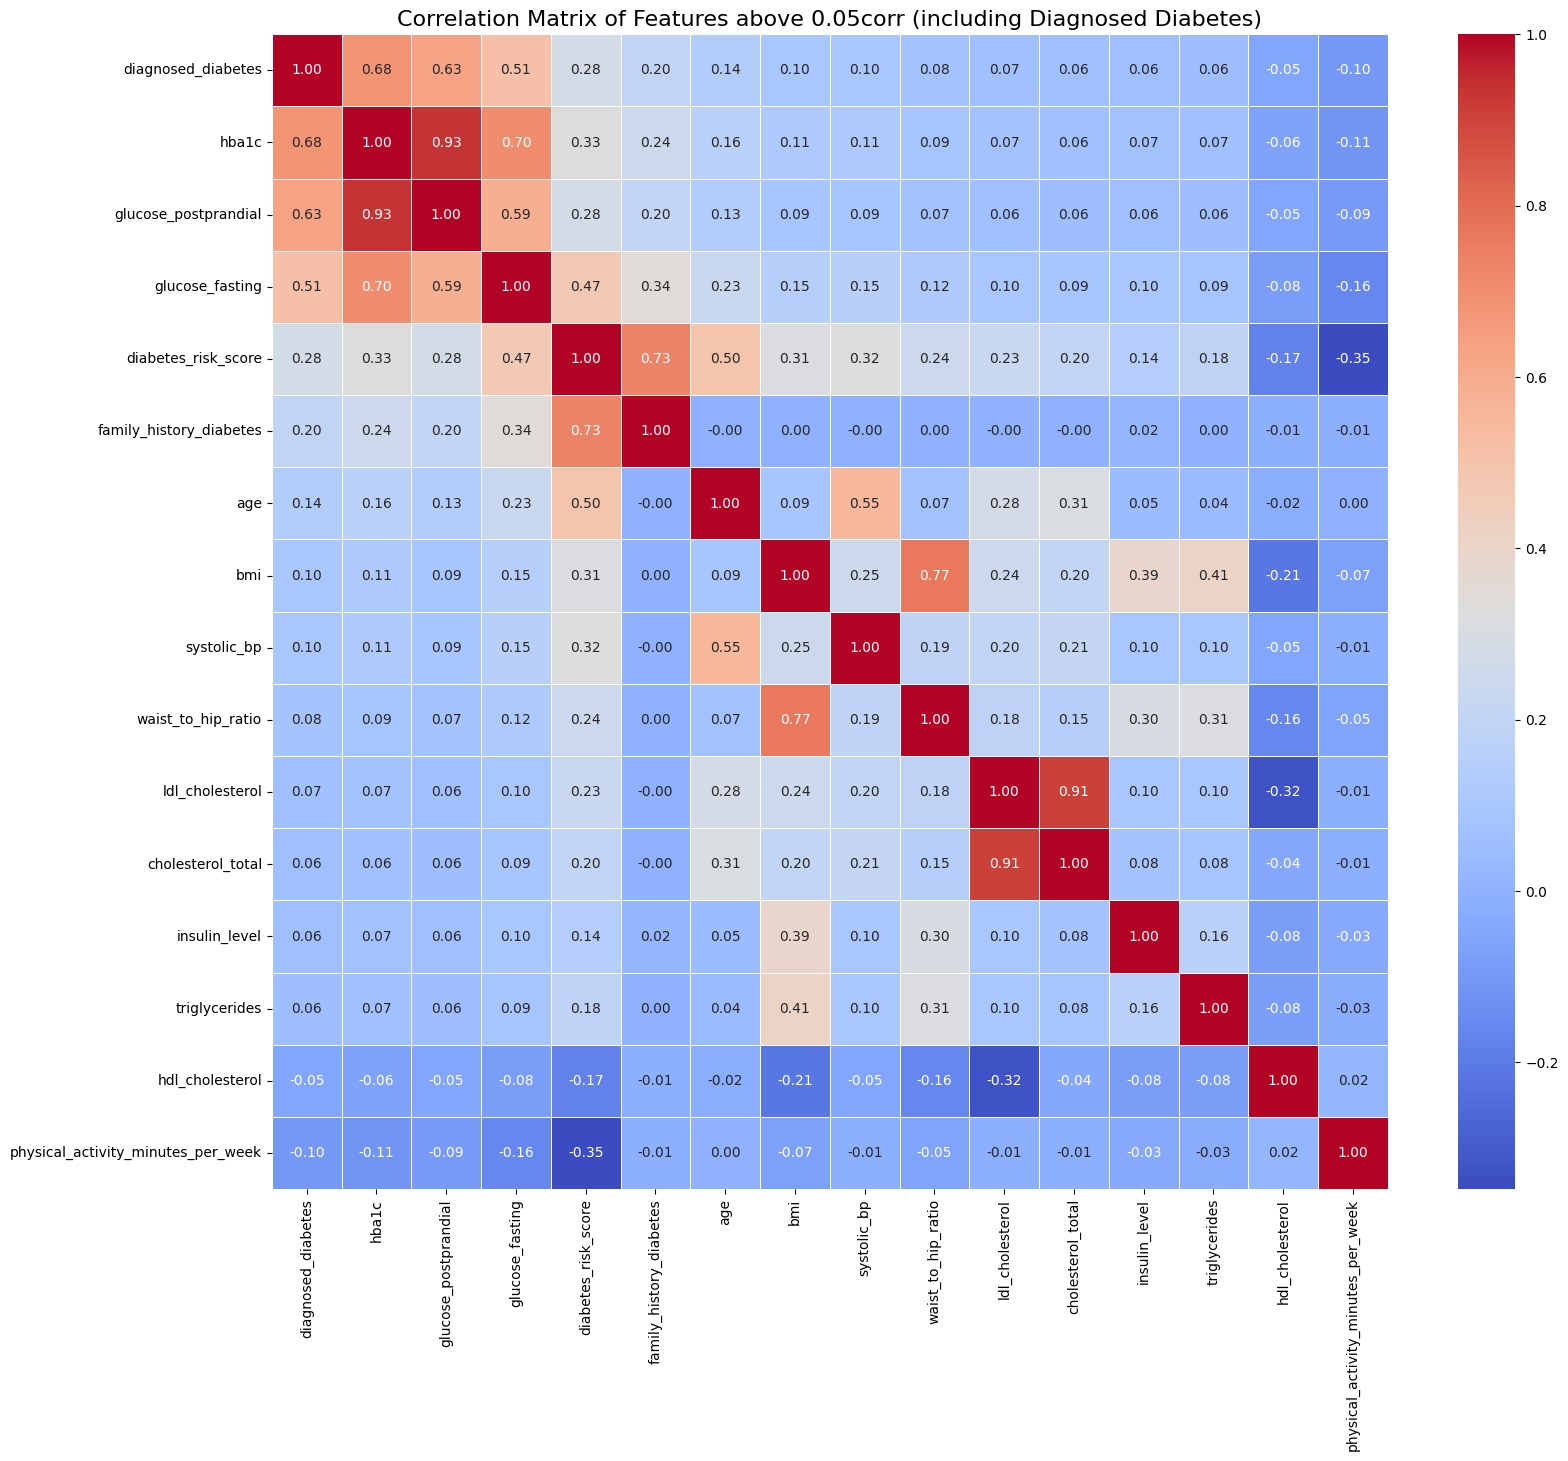

In [11]:
cols = selected_features_low_list.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.05corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()

# Selected Features and Correlation Matrix >=0.10

In [12]:
selected_features_high = correlationMatrix['diagnosed_diabetes']
selected_features_high = selected_features_high[selected_features_high.abs() >= 0.10]
selected_features_high = selected_features_high.sort_values(ascending=False)
print(selected_features_high)

diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


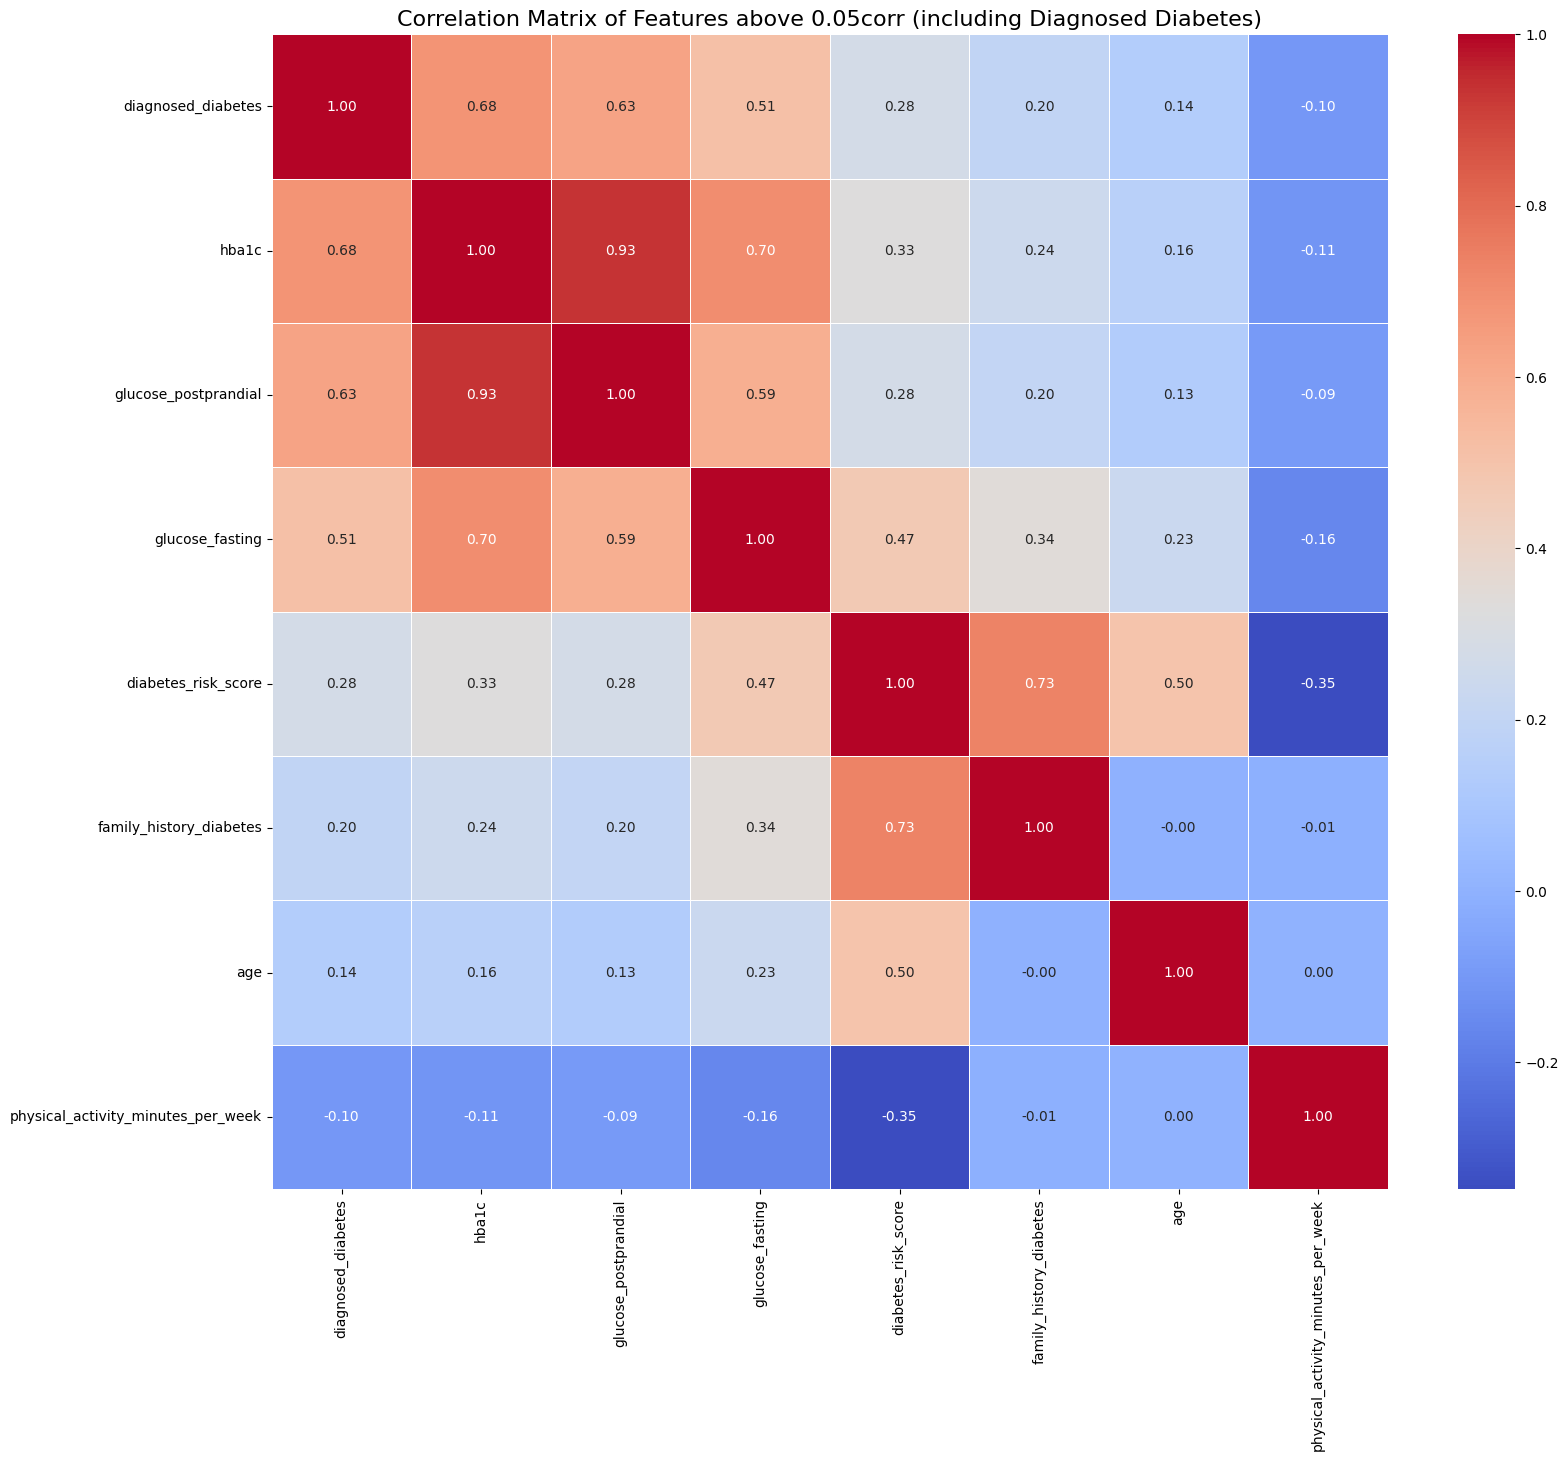

In [13]:
cols = selected_features_high.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.05corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()